#### Data Processing

In [1]:
# Imports and data

import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from scipy.signal import butter, filtfilt
import numpy as np
import mne
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

fs = 250  # Adjust based on EEG device
df = pd.read_csv("trial_3.csv", delimiter="\t", header=None) # Only analyzing trial 3
print(df.head())
print(f"Data Shape: {df.shape}")

      0            1            2             3             4              5   \
0  131.0  8553.073830  1238.264291  23291.009461  26226.799336 -187500.022352   
1  132.0  8544.893091  1252.994091  23262.712152  26134.151356 -187500.022352   
2  133.0  8541.562681  1263.275893  23226.390568  26041.950410 -187500.022352   
3  134.0  8553.766734  1270.093175  23257.526548  26130.820946 -187500.022352   
4  135.0  8560.472257  1263.030024  23297.849095  26235.874145 -187500.022352   

         6         7              8    9   ...    14   15    16   17     18  \
0  187500.0  187500.0 -187500.022352  0.0  ...  80.0  0.0  35.0  2.0  159.0   
1  187500.0  187500.0 -187500.022352  0.0  ...  81.0  0.0  35.0  2.0  159.0   
2  187500.0  187500.0 -187500.022352  0.0  ...  80.0  0.0  35.0  2.0  157.0   
3  187500.0  187500.0 -187500.022352  0.0  ...  80.0  0.0  35.0  2.0  158.0   
4  187500.0  187500.0 -187500.022352  0.0  ...  80.0  0.0  35.0  2.0  159.0   

      19    20     21            22   

In [2]:
# Importing the data using BrainFlow formatting

board_id = BoardIds.CYTON_BOARD.value # Assuming Cyton is the correct board ID
board_descr = BoardShim.get_board_descr(board_id)

# Channel indices
board_eeg_channels = board_descr["eeg_channels"]
timestamp_channel = board_descr["timestamp_channel"]
marker_channel = board_descr.get("marker_channel", None)
num_columns = df.shape[1]

# Assigning column names: I'm assuming these correctly apply to the data
# (ADJUST/DOUBLE CHECK)
column_names = ["Index"] + [f"EEG_{i}" for i in board_eeg_channels]

# Calculate remaining columns (subtract EEG, Index, Timestamp, and Marker)
num_other_cols = num_columns - len(column_names) - 2 
column_names += ["Other"] * num_other_cols

# Labeling timestamp and marker column names (again, assuming these are 
# being applied correctly)
column_names += ["Timestamp", "Marker"]

df.columns = column_names
print(df.head())

# Specifically the index, timestamp, and marker should all be correct
# not sure what the "other" columns represent, and I'm assuming the 
# 8 EEG channels are correctly labeled

# Extracting EEG data
eeg_data = df[[col for col in df.columns if "EEG" in col]]
timestamps = df["Timestamp"]
markers = df["Marker"]

print(f"EEG Data Shape: {eeg_data.shape}")
print(f"Timestamps Shape: {timestamps.shape}")
print(f"Markers Shape: {markers.shape}")

   Index        EEG_1        EEG_2         EEG_3         EEG_4          EEG_5  \
0  131.0  8553.073830  1238.264291  23291.009461  26226.799336 -187500.022352   
1  132.0  8544.893091  1252.994091  23262.712152  26134.151356 -187500.022352   
2  133.0  8541.562681  1263.275893  23226.390568  26041.950410 -187500.022352   
3  134.0  8553.766734  1270.093175  23257.526548  26130.820946 -187500.022352   
4  135.0  8560.472257  1263.030024  23297.849095  26235.874145 -187500.022352   

      EEG_6     EEG_7          EEG_8  Other  ...  Other  Other  Other  Other  \
0  187500.0  187500.0 -187500.022352    0.0  ...   80.0    0.0   35.0    2.0   
1  187500.0  187500.0 -187500.022352    0.0  ...   81.0    0.0   35.0    2.0   
2  187500.0  187500.0 -187500.022352    0.0  ...   80.0    0.0   35.0    2.0   
3  187500.0  187500.0 -187500.022352    0.0  ...   80.0    0.0   35.0    2.0   
4  187500.0  187500.0 -187500.022352    0.0  ...   80.0    0.0   35.0    2.0   

   Other  Other  Other  Other   

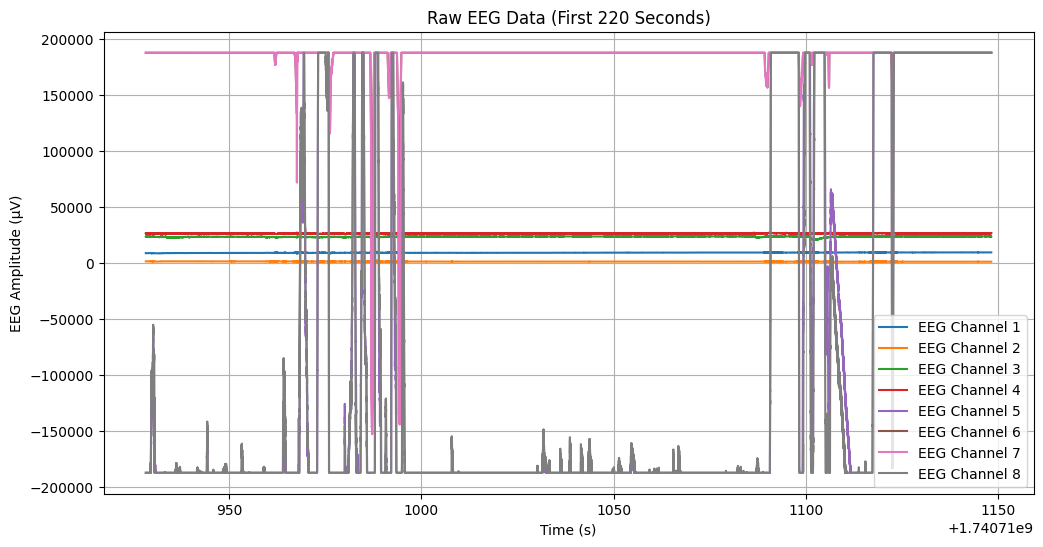

In [3]:
# Visualizing the data

# Plot all EEG channels for the first 220 seconds (~ 3 min, can change according
# to duration of experiment)
time_window = 220
start_idx = 0
end_idx = int(time_window * fs)

# Time and EEG data for the first window
time_segment = timestamps[start_idx:end_idx]
eeg_segment = eeg_data.iloc[start_idx:end_idx, :]

plt.figure(figsize=(12, 6))
for i, col in enumerate(eeg_segment.columns):
    plt.plot(time_segment, eeg_segment[col], label=f"EEG Channel {i+1}")

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title(f"Raw EEG Data (First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

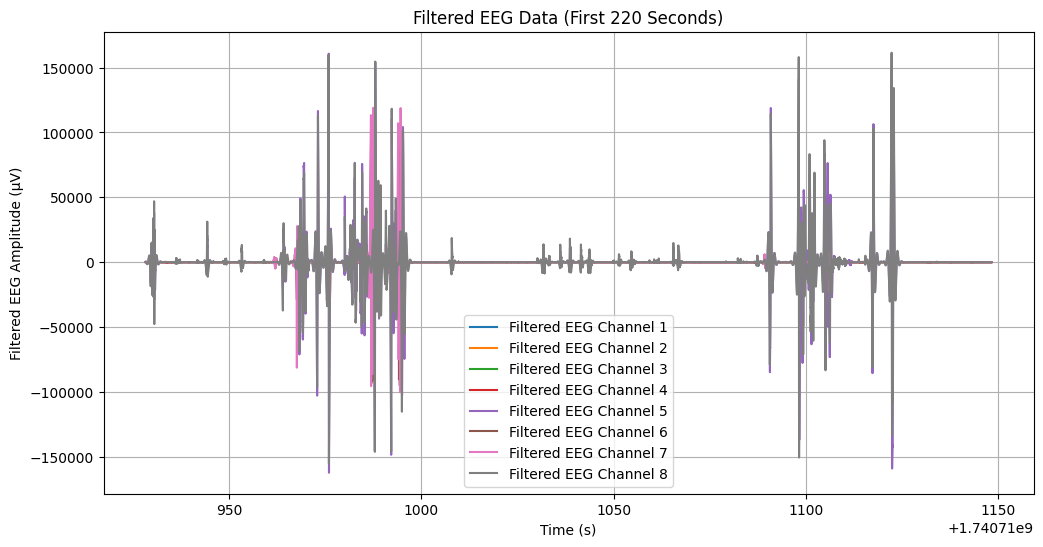

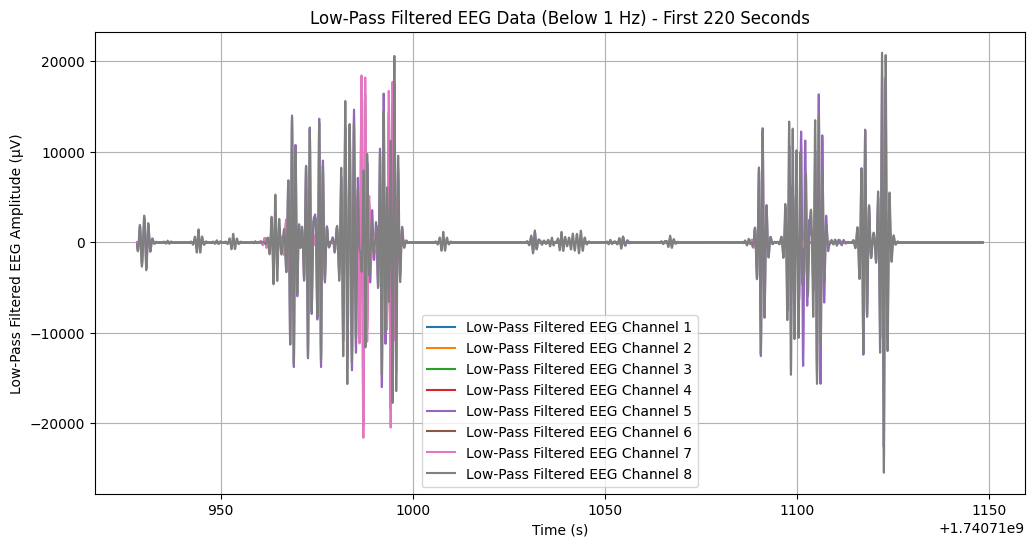

In [4]:
# Applying Bandpass and Lowpass Filters

# Bandpass filter function (1-50 Hz) to remove noise
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

filtered_eeg = eeg_data.apply(lambda x: bandpass_filter(x, 1, 50, fs))
filtered_eeg_segment = filtered_eeg.iloc[start_idx:end_idx, :]
plt.figure(figsize=(12, 6))
for i, col in enumerate(filtered_eeg_segment.columns):
    plt.plot(time_segment, filtered_eeg_segment[col], label=f"Filtered EEG Channel {i+1}")

plt.xlabel("Time (s)")
plt.ylabel("Filtered EEG Amplitude (µV)")
plt.title(f"Filtered EEG Data (First {time_window} Seconds)")
plt.legend()
plt.grid(True)
plt.show()

# Lowpass filter (below 1 Hz) to remove slow drifts
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

lowpass_filtered_eeg = filtered_eeg.apply(lambda x: lowpass_filter(x, 1, fs))
lowpass_filtered_eeg_segment = lowpass_filtered_eeg.iloc[start_idx:end_idx, :]
plt.figure(figsize=(12, 6))
for i, col in enumerate(lowpass_filtered_eeg_segment.columns):
    plt.plot(time_segment, lowpass_filtered_eeg_segment[col], label=f"Low-Pass Filtered EEG Channel {i+1}")

plt.xlabel("Time (s)")
plt.ylabel("Low-Pass Filtered EEG Amplitude (µV)")
plt.title(f"Low-Pass Filtered EEG Data (Below 1 Hz) - First {time_window} Seconds")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Defining events based on markers (can also try based on thresholds)
# (ADJUST/DOUBLE CHECK)
blink_times = timestamps[markers == 1]
jaw_clench_times = timestamps[markers == 2]
double_blink_times = timestamps[markers == 3]
jaw_clench_and_double_blink_times = timestamps[markers == 4] 

# Print detected events
print(f"Blink Times: {blink_times}")
print(f"Jaw Clench Times: {jaw_clench_times}")
print(f"Double Blink Times: {double_blink_times}")
print(f"Jaw Clench and Double Blink Times: {jaw_clench_and_double_blink_times}")

Blink Times: 49704    1.740711e+09
49705    1.740711e+09
52601    1.740711e+09
52602    1.740711e+09
53987    1.740711e+09
53988    1.740711e+09
65082    1.740711e+09
65083    1.740711e+09
66467    1.740711e+09
66469    1.740711e+09
70632    1.740711e+09
70633    1.740711e+09
72018    1.740711e+09
72019    1.740711e+09
73402    1.740711e+09
73403    1.740711e+09
76174    1.740711e+09
76175    1.740711e+09
84496    1.740711e+09
84497    1.740711e+09
88649    1.740711e+09
88650    1.740711e+09
96981    1.740711e+09
96982    1.740711e+09
98369    1.740711e+09
98370    1.740711e+09
Name: Timestamp, dtype: float64
Jaw Clench Times: 51212     1.740711e+09
51213     1.740711e+09
59534     1.740711e+09
59535     1.740711e+09
60923     1.740711e+09
60924     1.740711e+09
78947     1.740711e+09
78948     1.740711e+09
80332     1.740711e+09
80333     1.740711e+09
81717     1.740711e+09
81718     1.740711e+09
85879     1.740711e+09
85880     1.740711e+09
87264     1.740711e+09
87265     1.740711e+

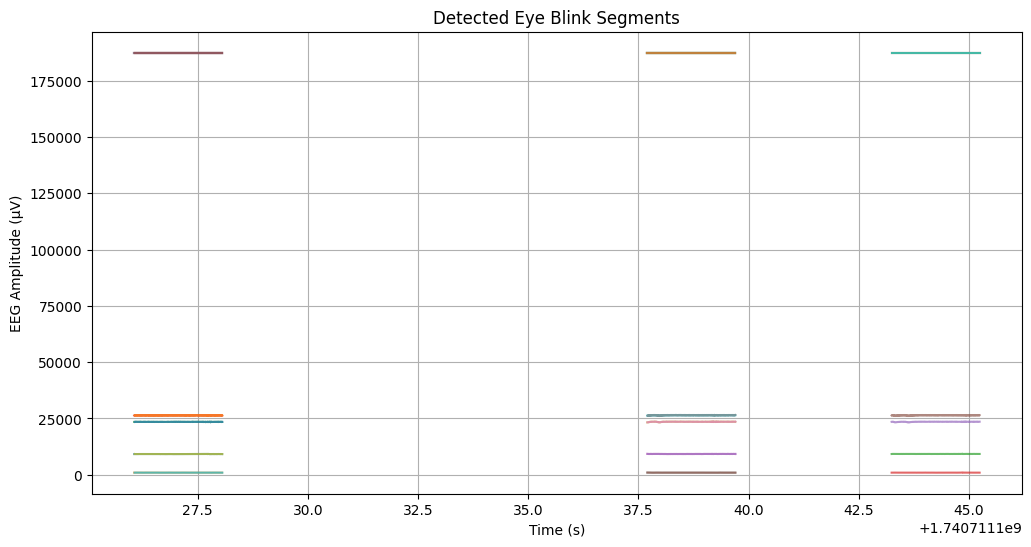

In [6]:
# Plot segments around events

event_window = 1  # 1 second window
samples_before = int(fs * event_window) 
samples_after = int(fs * event_window)

plt.figure(figsize=(12, 6))
for i, event_time in enumerate(timestamps[markers == 1][:5]):  # First 5 blinks
    event_idx = np.argmin(np.abs(timestamps - event_time))  # Event index
    segment = eeg_data.iloc[event_idx - samples_before : event_idx + samples_after, :]
    
    for channel in segment.columns:
        plt.plot(timestamps.iloc[event_idx - samples_before : event_idx + samples_after], 
                 segment[channel], alpha=0.7) # Applying to multiple channels
    
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("Detected Eye Blink Segments")
plt.grid(True)
plt.show()

Creating RawArray with float64 data, n_channels=8, n_times=104795
    Range : 0 ... 104794 =      0.000 ...   419.176 secs
Ready.
Using matplotlib as 2D backend.


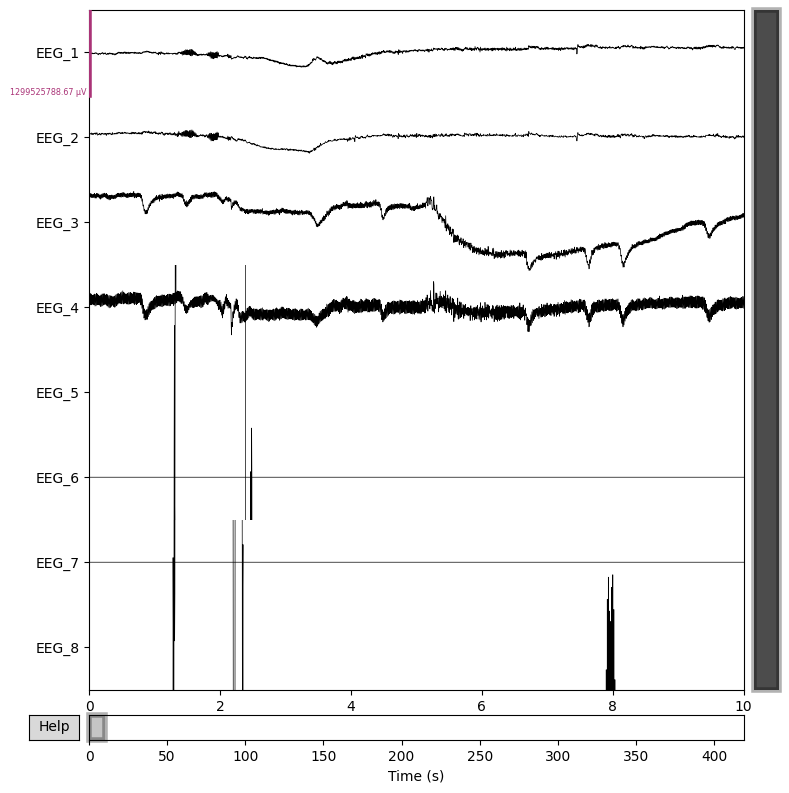

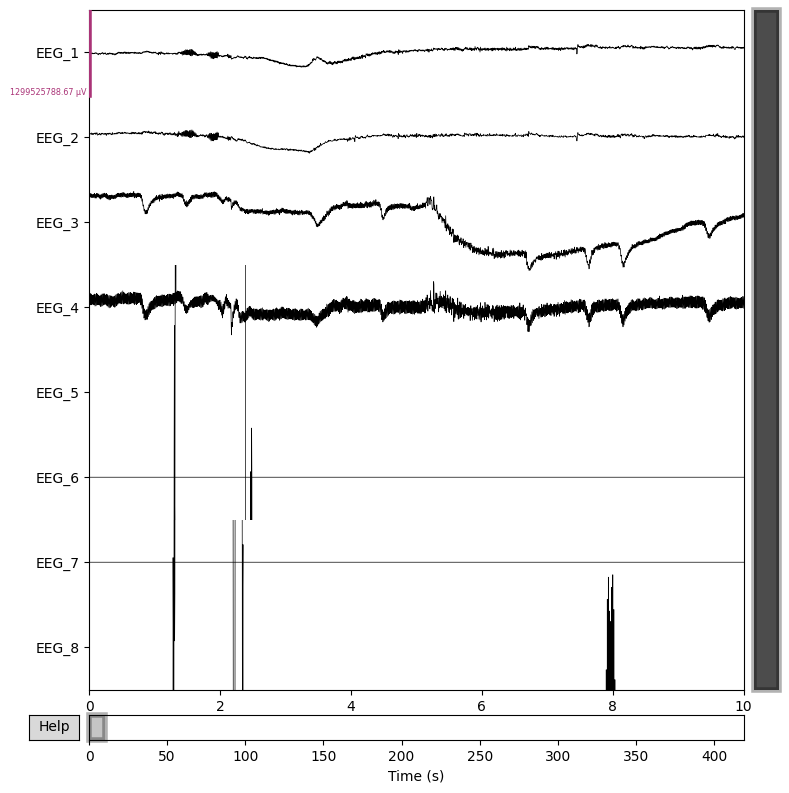

In [7]:
# MNE visualization

channel_names = [f"EEG_{i}" for i in range(1, 9)]
sfreq = fs
raw_data = eeg_data.to_numpy().T 

# Create an MNE Info object 
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(raw_data, info)
raw.plot(duration=10, n_channels=8, scalings='auto', title="Raw EEG Data", show=True)

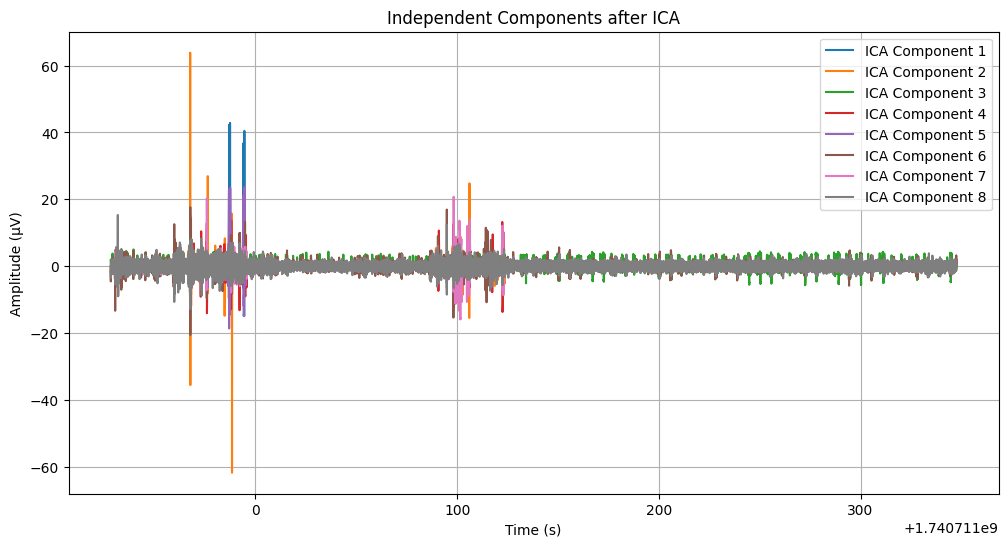

In [8]:
# ICA for artifact removal

# May need to go back and identify and remove artifact components manually
ica = FastICA(n_components=len(channel_names), random_state=0)
eeg_data_ica = ica.fit_transform(filtered_eeg)

# Plot independent components
plt.figure(figsize=(12, 6))
for i in range(len(channel_names)):
    plt.plot(timestamps, eeg_data_ica[:, i], label=f"ICA Component {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Independent Components after ICA")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Defining events based on the marker column

def parse_events(df):
    events = {'blink': [], 'jaw_clench': [], 'double_blink': [], 'jaw_clench_and_double_blink': []}
    for idx, marker in enumerate(df["Marker"]):
        timestamp = df["Timestamp"].iloc[idx]
        # Assuming marker '1' is for blink, '2' for jaw clench, so on
        # (ADJUST/DOUBLE CHECK)
        if marker == 1: 
            events['blink'].append(timestamp)
        elif marker == 2:
            events['jaw_clench'].append(timestamp)
        elif marker == 3:
            events['double_blink'].append(timestamp)
        elif marker == 4:
            events['jaw_clench_and_double_blink'].append(timestamp)
    return events
events = parse_events(df)

# Detected events and their timestamps
print(f"Blink Events: {events['blink']}")
print(f"Jaw Clench Events: {events['jaw_clench']}")
print(f"Double Blink Events: {events['double_blink']}")
print(f"Jaw Clench and Double Blink Events: {events['jaw_clench_and_double_blink']}")

Blink Events: [np.float64(1740711127.06056), np.float64(1740711127.064616), np.float64(1740711138.701747), np.float64(1740711138.706746), np.float64(1740711144.246485), np.float64(1740711144.25049), np.float64(1740711188.625623), np.float64(1740711188.630655), np.float64(1740711194.166288), np.float64(1740711194.173401), np.float64(1740711210.826593), np.float64(1740711210.830645), np.float64(1740711216.369493), np.float64(1740711216.37349), np.float64(1740711221.905479), np.float64(1740711221.909342), np.float64(1740711232.99276), np.float64(1740711232.99677), np.float64(1740711266.281272), np.float64(1740711266.285282), np.float64(1740711282.893702), np.float64(1740711282.898726), np.float64(1740711316.224849), np.float64(1740711316.226736), np.float64(1740711321.774487), np.float64(1740711321.778532)]
Jaw Clench Events: [np.float64(1740711133.147234), np.float64(1740711133.151288), np.float64(1740711166.433328), np.float64(1740711166.438318), np.float64(1740711171.990295), np.float6

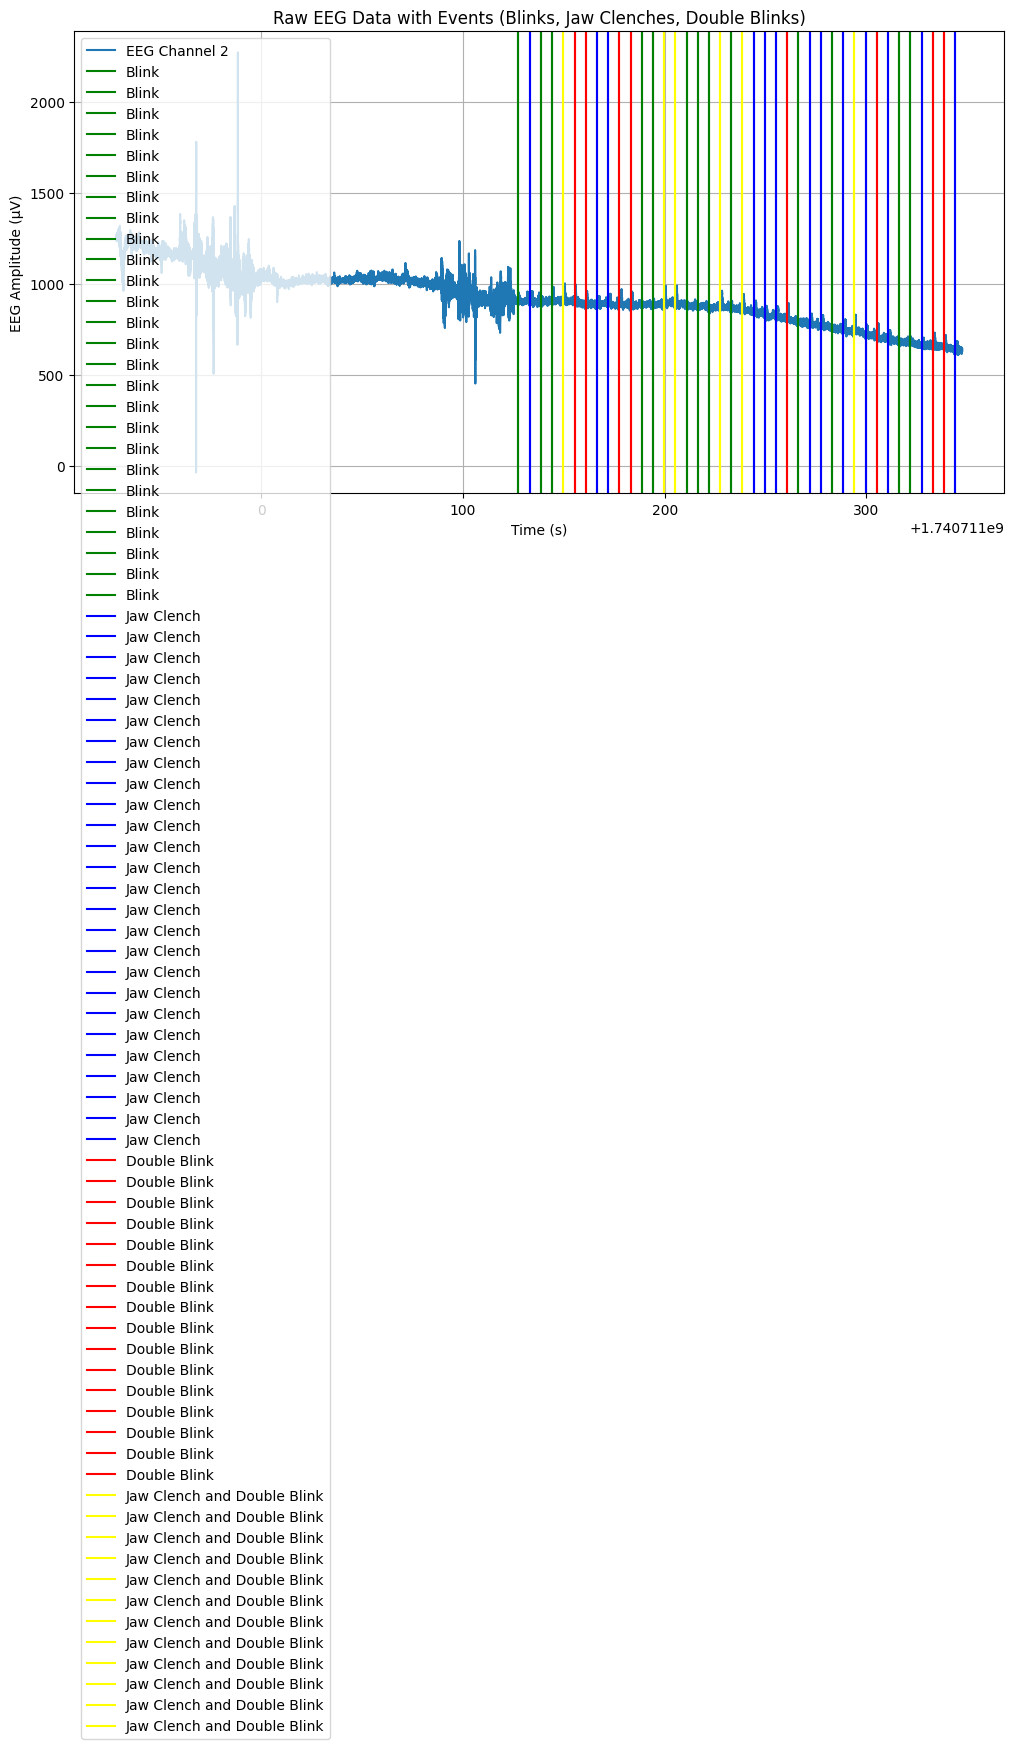

In [10]:
# Plotting data with event markers

plt.figure(figsize=(12, 6))
chan_id = 1  # Choosing channel to visualize
plt.plot(df["Timestamp"], eeg_data.iloc[:, chan_id], label=f"EEG Channel {chan_id + 1}")

# Blink events
for blink_time in events['blink']:
    plt.axvline(x=blink_time, color='green', label='Blink')
# Jaw clench events
for jaw_time in events['jaw_clench']:
    plt.axvline(x=jaw_time, color='blue', label='Jaw Clench')
# Double blink events
for dbl_blink_time in events['double_blink']:
    plt.axvline(x=dbl_blink_time, color='red', label='Double Blink')
# Jaw clench and double blink events
for dbl_blink_time in events['jaw_clench_and_double_blink']:
    plt.axvline(x=dbl_blink_time, color='yellow', label='Jaw Clench and Double Blink')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("Raw EEG Data with Events (Blinks, Jaw Clenches, Double Blinks)")
plt.legend()
plt.grid(True)
plt.show()

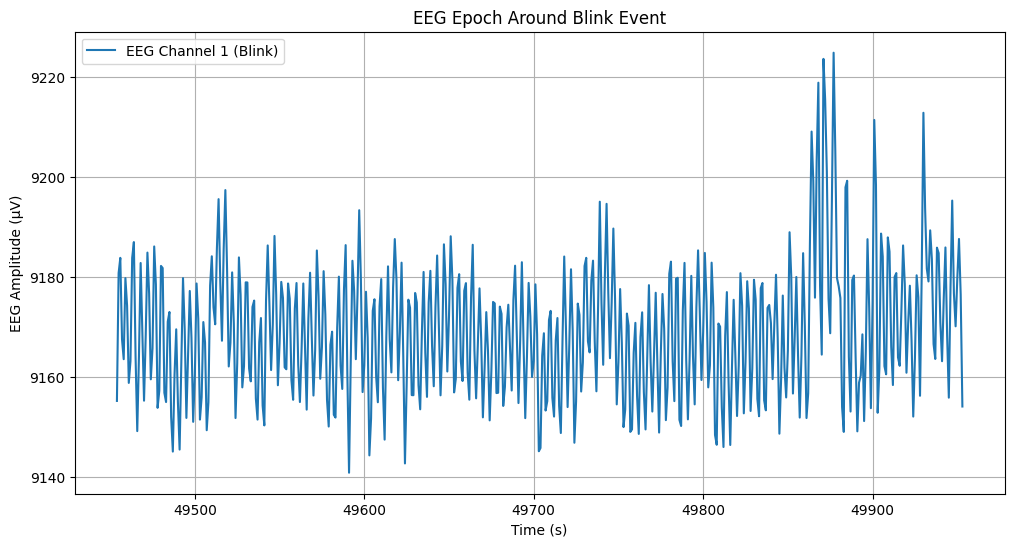

In [11]:
# Define a window and extract epochs

event_window = 1 
samples_before = int(fs * event_window)
samples_after = int(fs * event_window)

# Extracting epochs around blink events (can choose to do this for other events also)
epochs_blink = []
for blink_time in timestamps[markers == 1]:  # Blink event (adjust accordingly)
    blink_idx = np.argmin(np.abs(df["Timestamp"] - blink_time))
    epoch = eeg_data.iloc[blink_idx - samples_before: blink_idx + samples_after, :]
    epochs_blink.append(epoch)

# Plot first epoch for a blink event
plt.figure(figsize=(12, 6))
plt.plot(epochs_blink[0].index, epochs_blink[0].iloc[:, 0], label="EEG Channel 1 (Blink)")
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Epoch Around Blink Event")
plt.legend()
plt.grid(True)
plt.show()

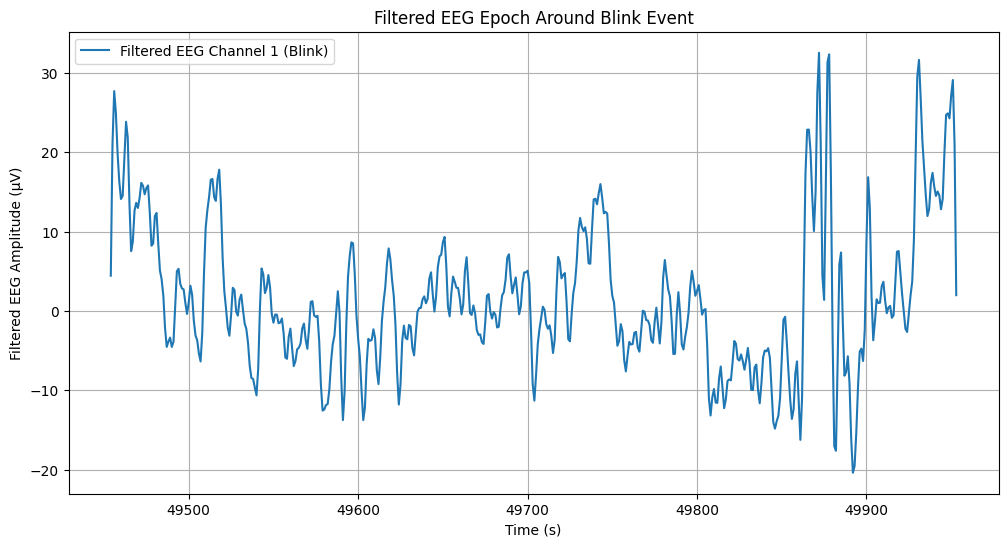

In [12]:
# Applying bandpass filter to epoch

def filter_epoch(epoch, lowcut=1, highcut=50, fs=250):
    return epoch.apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))
filtered_epochs_blink = [filter_epoch(epoch) for epoch in epochs_blink]

# Visualize filtered data for first blink epoch
plt.figure(figsize=(12, 6))
plt.plot(filtered_epochs_blink[0].index, filtered_epochs_blink[0].iloc[:, 0], label="Filtered EEG Channel 1 (Blink)")
plt.xlabel("Time (s)")
plt.ylabel("Filtered EEG Amplitude (µV)")
plt.title("Filtered EEG Epoch Around Blink Event")
plt.legend()
plt.grid(True)
plt.show()